<a href="https://colab.research.google.com/github/walnuthoram2/ALNS/blob/master/VRP_ALNS_my.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github

https://alns.readthedocs.io/en/latest/examples/capacitated_vehicle_routing_problem.html

#Data 불러오기

In [ ]:
!pip install 'alns @ git+https://github.com/walnuthoram2/alns'

  Cloning https://github.com/walnuthoram2/alns to /tmp/pip-install-a2n0iz_1/alns_bba0fc25d2eb4fb28b0d94434b519d6d
  Running command git clone --filter=blob:none --quiet https://github.com/walnuthoram2/alns /tmp/pip-install-a2n0iz_1/alns_bba0fc25d2eb4fb28b0d94434b519d6d
  Resolved https://github.com/walnuthoram2/alns to commit 8ba825e8c435d5f3a9ef1622cf175b90fe5952ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install alns
!pip install vrplib
import copy
from types import SimpleNamespace

import vrplib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxIterations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.3 MB/s eta 0:00:00


In [ ]:
#주피터 노트북에서 그래프 바로 그릴 때 사용
%matplotlib inline

In [ ]:
SEED = 1234 #무작위의 랜덤값을 고정시키는 역할

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#내 드라이브 안에 파일 있는지 확인
import os
file_path = "/content/drive/My Drive/data/P-n16-k8.vrp.txt"
if os.path.exists(file_path):
    print(f"파일 {file_path} 존재함")
else:
    print(f"파일 {file_path} 없음. 경로를 확인하세요.")

파일 /content/drive/My Drive/data/P-n16-k8.vrp.txt 존재함


In [ ]:
#raw data와 sol 입력(best konwn solution)
data = vrplib.read_instance("/content/drive/My Drive/data/P-n16-k8.vrp.txt")
bks = SimpleNamespace(**vrplib.read_solution("/content/drive/My Drive/data/P-n16-k8.sol.txt"))

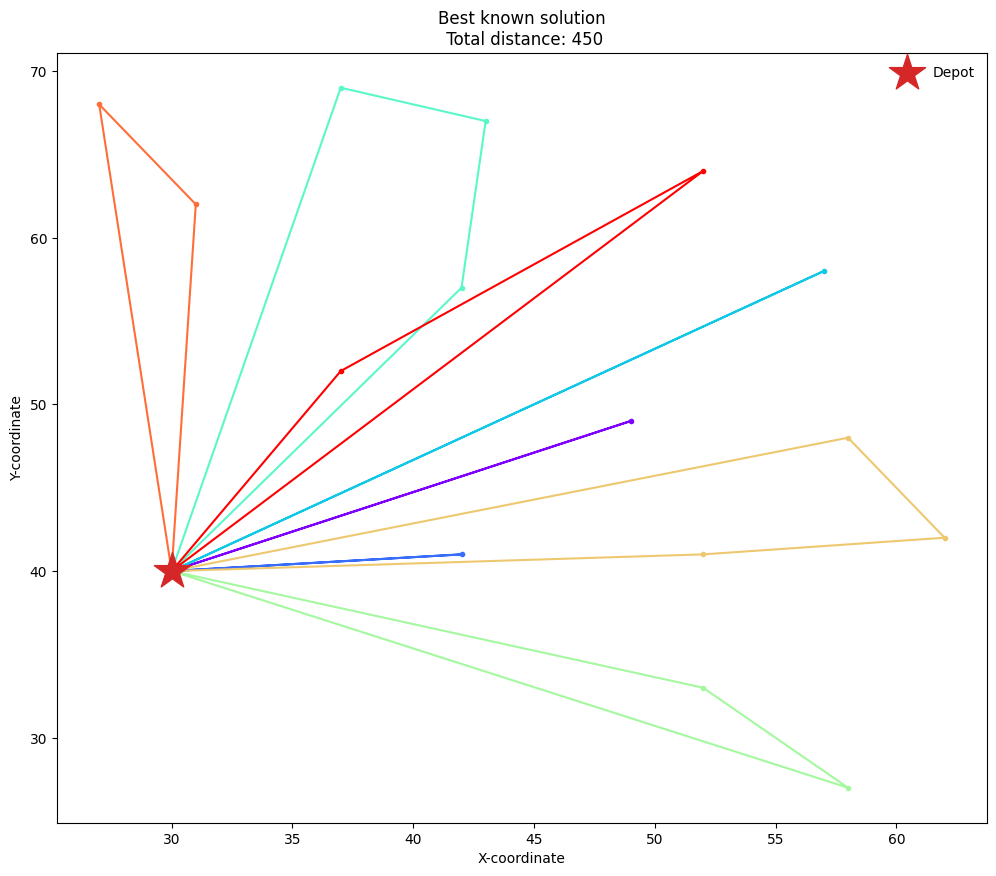

In [ ]:
def plot_solution(solution, name="CVRP solution"):
    """
    Plot the routes of the passed-in solution.
    """
    #plot그리기
    fig, ax = plt.subplots(figsize=(12, 10))

    #무지개 색상 할당, 솔루션 개수만큼 균등하게 값 분할
    cmap = matplotlib.cm.rainbow(np.linspace(0, 1, len(solution.routes)))

    #경로 그리기
    #0+route+0 으로 경로 설정 후, loc0의 x좌표, loc1의 y좌표 뽑아내서 cmap에서 색 받아서 그림
    for idx, route in enumerate(solution.routes):
        ax.plot(
            [data["node_coord"][loc][0] for loc in [0] + route + [0]],
            [data["node_coord"][loc][1] for loc in [0] + route + [0]],
            color=cmap[idx],
            marker=".",
        )

    # depot 그리기
    #zorder은 제일 위에 그리도록 우선순위 설정
    kwargs = dict(label="Depot", zorder=3, marker="*", s=750)
    #뽑아낸 x, y 좌표를 *연산자를 통해 인자로 전달
    ax.scatter(*data["node_coord"][0], c="tab:red", **kwargs)

    #plot 꾸미기
    #제목, x, y 축, 범례는 테두리 제거
    ax.set_title(f"{name}\n Total distance: {solution.cost}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)

plot_solution(bks, name="Best known solution")

# solution

In [ ]:
#CVRP문제의 solution 저장 및 여러 기능 묶어둠
class CvrpState:
    """
    Solution state for CVRP. It has two data members, routes and unassigned.
    Routes is a list of list of integers, where each inner list corresponds to
    a single route denoting the sequence of customers to be visited. A route
    does not contain the start and end depot. Unassigned is a list of integers,
    each integer representing an unassigned customer.
    """

    #생성자
    #routes 인자를 받아서 할당해줌, 인자 제공 되지 않으면 빈 리스트
    def __init__(self, routes, unassigned=None):
        self.routes = routes
        self.unassigned = unassigned if unassigned is not None else []

    #copy 메서드
    #원본 copy 하여 새로운 객체 반환
    def copy(self):
        return CvrpState(copy.deepcopy(self.routes), self.unassigned.copy())

    #objective 메서드
    #목적함수 값 계산하여 반환
    def objective(self):
        """
        Computes the total route costs.
        """
        return sum(route_cost(route) for route in self.routes)

    #cost 프로퍼티
    #objective 메서드의 결과를 반환하는 별칭역할
    @property
    def cost(self):
        """
        Alias for objective method. Used for plotting.
        """
        return self.objective()

    #find_route 메서드
    def find_route(self, customer):
        """
        Return the route that contains the passed-in customer.
        """
        for route in self.routes:
            if customer in route:
                return route

        raise ValueError(f"Solution does not contain customer {customer}.")

#route_cost함수
#총 비용 계산
def route_cost(route):
    distances = data["edge_weight"]
    tour = [0] + route + [0]

    return sum(
        distances[tour[idx]][tour[idx + 1]] for idx in range(len(tour) - 1)
    )

In [ ]:
class CvrpState:
    def __init__(self, routes, unassigned=None):
        self.routes = routes
        self.unassigned = unassigned if unassigned is not None else []

    def copy(self):
        return CvrpState(copy.deepcopy(self.routes), self.unassigned.copy())

    def objective(self):
        return sum(route_cost(route) for route in self.routes)

    @property
    def cost(self):
        return self.objective()

    def find_route(self, customer):
        for route in self.routes:
            if customer in route:
                return route
        raise ValueError(f"Solution does not contain customer {customer}.")

def route_cost(route):
    distances = data["edge_weight"]
    tour = [0] + route + [0]
    return sum(distances[tour[idx]][tour[idx + 1]] for idx in range(len(tour) - 1))

# Destroy operators

In [ ]:
degree_of_destruction = 0.2
customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction)

#무작위로 선택된 5명을 파괴
def random_removal(state, rng):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    #원본 살리고 복사본에서 제거 진행
    destroyed = state.copy()

    #범위내에서 무작위로 제거
    #제거된 노드 미배정 노드에 추가, 이 노드가 속한 경로 찾기, 경로에서 노드 제거
    for customer in rng.choice(
        range(1, data["dimension"]), customers_to_remove, replace=False
    ):
        destroyed.unassigned.append(customer)
        route = destroyed.find_route(customer)
        route.remove(customer)

    return remove_empty_routes(destroyed)

#제거 후, 노드가 없는 빈 경로 제거
def remove_empty_routes(state):
    """
    Remove empty routes after applying the destroy operator.
    """
    state.routes = [route for route in state.routes if len(route) != 0]
    return state

In [ ]:
degree_of_destruction = 0.2
customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction)

def random_removal(state, rng):
    destroyed = state.copy()

    for customer in rng.choice(range(1, data["dimension"]), customers_to_remove, replace=False):
        destroyed.unassigned.append(customer)
        route = destroyed.find_route(customer)
        route.remove(customer)

    return remove_empty_routes(destroyed)

def remove_empty_routes(state):
    state.routes = [route for route in state.routes if len(route) != 0]
    return state

#Repair operatiors

In [ ]:
#앞서 파괴로 미배정으로 이동한 노드를 greedy로 재삽입
#삽입 안되면 새로운 경로 생성
def greedy_repair(state, rng):
    """
    Inserts the unassigned customers in the best route. If there are no
    feasible insertions, then a new route is created.
    """
    rng.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = best_insert(customer, state)

        if route is not None:
            route.insert(idx, customer)
        else:
            state.routes.append([customer])

    return state

#노드 삽입 시, 비용이 최소화 되는 방법 도출
def best_insert(customer, state):
    """
    Finds the best feasible route and insertion idx for the customer.
    Return (None, None) if no feasible route insertions are found.
    """
    best_cost, best_route, best_idx = None, None, None

    for route in state.routes:
        for idx in range(len(route) + 1):

            if can_insert(customer, route):
                cost = insert_cost(customer, route, idx)

                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx

    return best_route, best_idx

#차량의 capa 넘지 않는지 체크
def can_insert(customer, route):
    """
    Checks if inserting customer does not exceed vehicle capacity.
    """
    total = data["demand"][route].sum() + data["demand"][customer]
    return total <= data["capacity"]

#앞서 살펴본 비용 도출 시에 사용되는 계산 과정
def insert_cost(customer, route, idx):
    """
    Computes the insertion cost for inserting customer in route at idx.
    """
    dist = data["edge_weight"]
    pred = 0 if idx == 0 else route[idx - 1]
    succ = 0 if idx == len(route) else route[idx]

    # Increase in cost of adding customer, minus cost of removing old edge
    return dist[pred][customer] + dist[customer][succ] - dist[pred][succ]

In [ ]:
def greedy_repair(state, rng):
    rng.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = best_insert(customer, state)
        if route is not None:
            route.insert(idx, customer)
        else:
            state.routes.append([customer])
    return state

def best_insert(customer, state):
    best_cost, best_route, best_idx = None, None, None

    for route in state.routes:
        for idx in range(len(route) + 1):
            if can_insert(customer, route):
                cost = insert_cost(customer, route, idx)
                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx
    return best_route, best_idx

def can_insert(customer, route):
    total = data["demand"][route].sum() + data["demand"][customer]
    return total <= data["capacity"]

def insert_cost(customer, route, idx):
    dist = data["edge_weight"]
    pred = 0 if idx == 0 else route[idx - 1]
    succ = 0 if idx == len(route) else route[idx]
    return dist[pred][customer] + dist[customer][succ] - dist[pred][succ]

#Initial solution

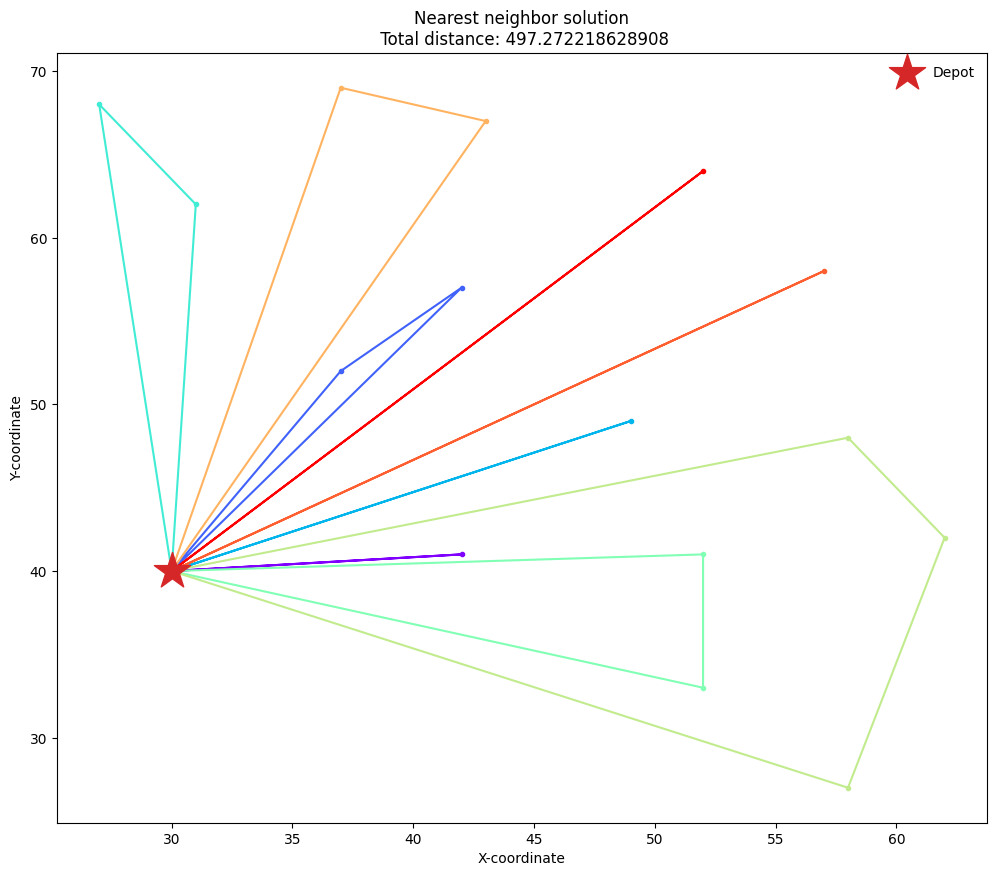

In [ ]:
#최근접을 찾기 위해 노드와의 거리 중 가장 가까운 순서대로 반환
def neighbors(customer):
    """
    Return the nearest neighbors of the customer, excluding the depot.
    """
    locations = np.argsort(data["edge_weight"][customer])
    return locations[locations != 0]

#NN 사용해 초기해 구성
#빈 리스트에 가까운 순으로 경로 추가, 남은 노드 없을 때까지
def nearest_neighbor():
    """
    Build a solution by iteratively constructing routes, where the nearest
    customer is added until the route has met the vehicle capacity limit.
    """
    routes = []
    unvisited = set(range(1, data["dimension"]))

    while unvisited:
        route = [0]  # Start at the depot
        route_demands = 0

        while unvisited:
            # Add the nearest unvisited customer to the route till max capacity
            current = route[-1]
            nearest = [nb for nb in neighbors(current) if nb in unvisited][0]

            if route_demands + data["demand"][nearest] > data["capacity"]:
                break

            route.append(nearest)
            unvisited.remove(nearest)
            route_demands += data["demand"][nearest]

        customers = route[1:]  # Remove the depot
        routes.append(customers)

    return CvrpState(routes)

#plot 그리기
plot_solution(nearest_neighbor(), "Nearest neighbor solution")

#Heuristic solution

In [ ]:
#ALNS 구현, seed값 고정
alns = ALNS(rnd.default_rng(SEED))

#alns객체에 파괴 및 수리 연산자 추가
alns.add_destroy_operator(random_removal)
alns.add_repair_operator(greedy_repair)

In [ ]:
import time
start_time = time.time()
#최대 반복횟수 10000, 초기해는 nn에서 만든 sol 사용
num_iterations = 10000
init = nearest_neighbor()
#어떤 연산자 사용할지 선택은 룰렛휠 방식
#가중치에 따라 확률을 적용해서 선택
#accept에서 RecordToRecordTravel기법 사용하여 새로운 sol 사용할지 결정
#나쁜 해도 수용, 지역최적해에 빠지지 않기 위해 범위 넓게 잡고 다양한 해 수용하고 좁혀가는 방식
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = RecordToRecordTravel.autofit(
    init.objective(), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)

result = alns.iterate(init, select, accept, stop)

end_time = time.time()
elapsed = end_time - start_time
print(f"실행 시간: {elapsed:.6f} 초")

실행 시간: 12.170474 초


In [ ]:
solution = result.best_state
objective = solution.objective()
#최적과 몇% 차이나는지 계산
pct_diff = 100 * (objective - bks.cost) / bks.cost

print(f"Best heuristic objective is {objective}.")
print(
    f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bks.cost}."
)

Best heuristic objective is 6208.0.
This is 0.0% worse than the optimal solution, which is 6208.


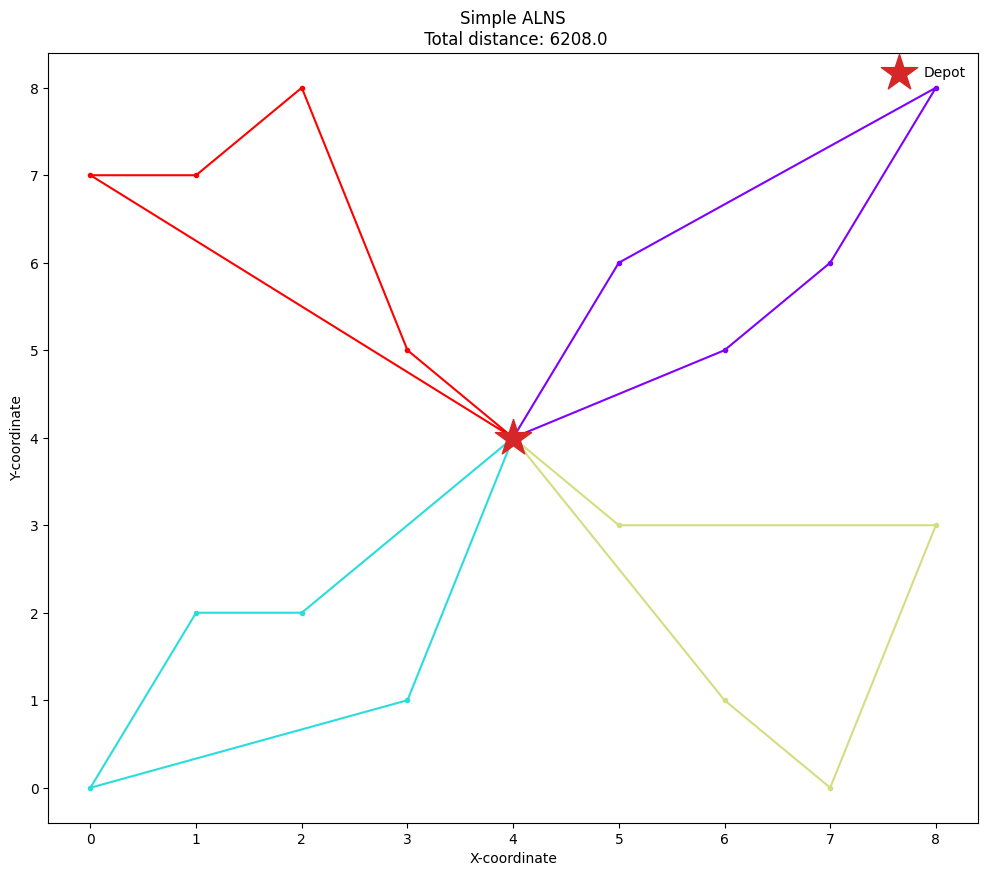

In [ ]:
plot_solution(solution, "Simple ALNS")

In [ ]:
import time
start_time = time.time()
end_time = time.time()
gap = end_time - start_time
print(f"실행 시간: {gap:.6f} 초")

실행 시간: 0.000120 초


In [ ]:
alns = ALNS(rnd.default_rng(SEED))
alns.add_destroy_operator(random_removal)
alns.add_repair_operator(greedy_repair)

Best heuristic objective is 451.33508020861797, iterations=30000.
This is 0.3% worse than the optimal solution, which is 450.
실행 시간: 20.894613 초


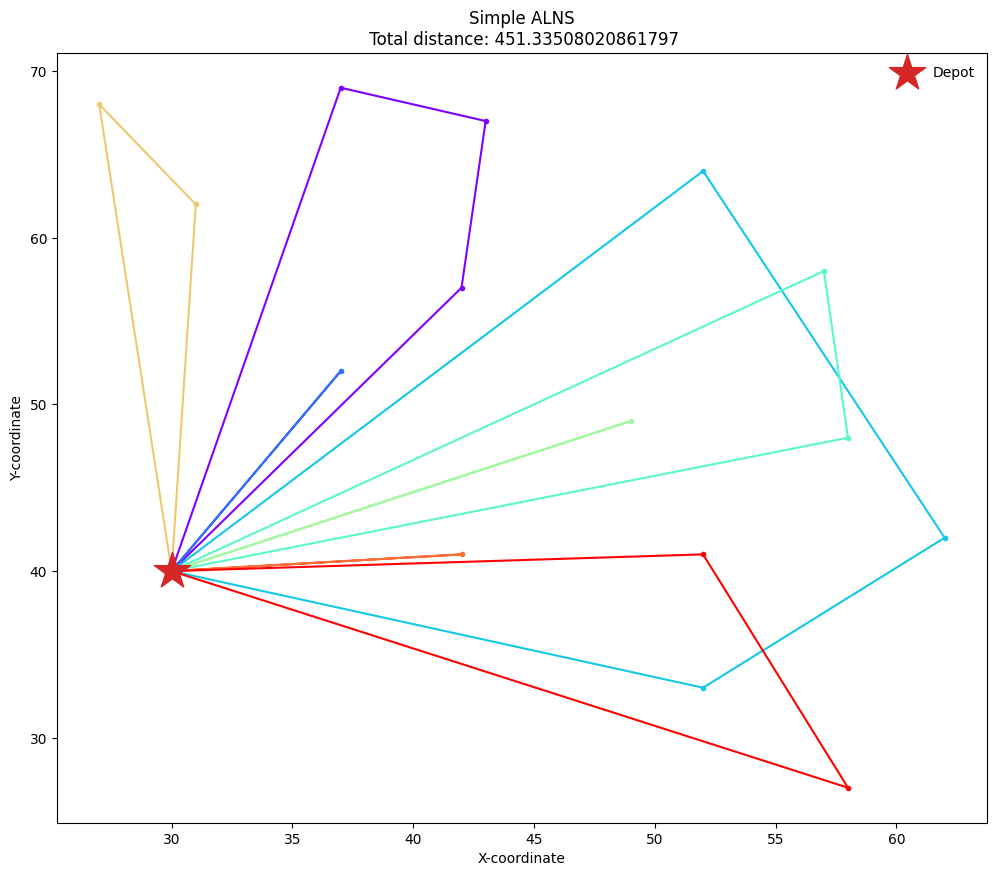

In [ ]:
import time
start_time = time.time()

num_iterations = 30000
init = nearest_neighbor()
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = RecordToRecordTravel.autofit(init.objective(), 0.02, 0, num_iterations)
stop = MaxIterations(num_iterations)
result = alns.iterate(init, select, accept, stop)
solution = result.best_state
objective = solution.objective()
pct_diff = 100 * (objective - bks.cost) / bks.cost
print(f"Best heuristic objective is {objective}, iterations={num_iterations}.")
print(f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bks.cost}.")
plot_solution(solution, "Simple ALNS")

end_time = time.time()
elapsed = end_time - start_time
print(f"실행 시간: {elapsed:.6f} 초")

In [ ]:
solution = result.best_state
objective = solution.objective()
pct_diff = 100 * (objective - bks.cost) / bks.cost
print(f"Best heuristic objective is {objective}, iterations={num_iterations}.")
print(f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bks.cost}.")

Best heuristic objective is 7032.0, iterations=3000.
This is 13.3% worse than the optimal solution, which is 6208.


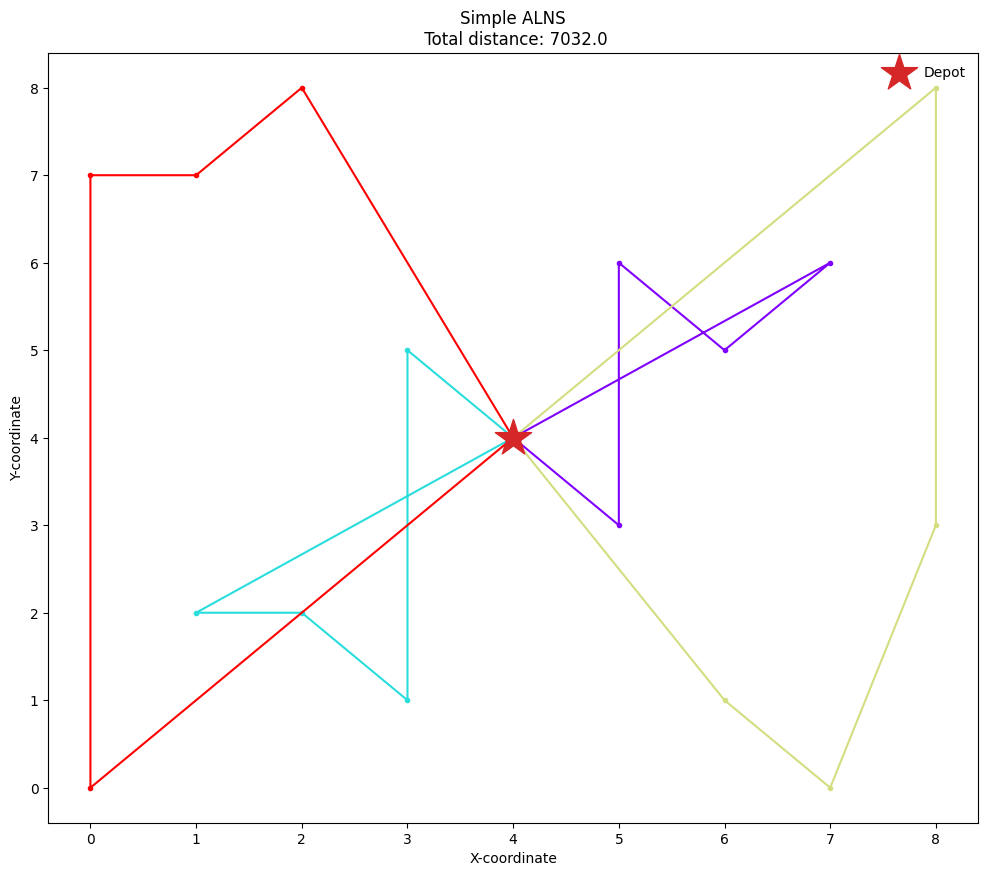

In [ ]:
plot_solution(solution, "Simple ALNS")

#Slack-induced substring removal

In [ ]:
MAX_STRING_REMOVALS = 2
MAX_STRING_SIZE = 12

def string_removal(state, rng):
    """
    Remove partial routes around a randomly chosen customer.
    """
    destroyed = state.copy()

    avg_route_size = int(np.mean([len(route) for route in state.routes]))
    max_string_size = max(MAX_STRING_SIZE, avg_route_size)
    max_string_removals = min(len(state.routes), MAX_STRING_REMOVALS)

    destroyed_routes = []
    center = rng.integers(1, data["dimension"])

    for customer in neighbors(center):
        if len(destroyed_routes) >= max_string_removals:
            break

        if customer in destroyed.unassigned:
            continue

        route = destroyed.find_route(customer)
        if route in destroyed_routes:
            continue

        customers = remove_string(route, customer, max_string_size, rng)
        destroyed.unassigned.extend(customers)
        destroyed_routes.append(route)

    return destroyed


def remove_string(route, cust, max_string_size, rng):
    """
    Remove a string that constains the passed-in customer.
    """
    # Find consecutive indices to remove that contain the customer
    size = rng.integers(1, min(len(route), max_string_size) + 1)
    start = route.index(cust) - rng.integers(size)
    idcs = [idx % len(route) for idx in range(start, start + size)]

    # Remove indices in descending order
    removed_customers = []
    for idx in sorted(idcs, reverse=True):
        removed_customers.append(route.pop(idx))

    return removed_customers

In [ ]:
MAX_STRING_REMOVALS = 2
MAX_STRING_SIZE = 12

def string_removal(state, rng):
    destroyed = state.copy()
    avg_route_size = int(np.mean([len(route) for route in state.routes]))
    max_string_size = max(MAX_STRING_SIZE, avg_route_size)
    max_string_removals = min(len(state.routes), MAX_STRING_REMOVALS)
    destroyed_routes = []
    center = rng.integers(1, data["dimension"])

    for customer in neighbors(center):
        if len(destroyed_routes) >= max_string_removals:
            break
        if customer in destroyed.unassigned:
            continue
        route = destroyed.find_route(customer)
        if route in destroyed_routes:
            continue
        customers = remove_string(route, customer, max_string_size, rng)
        destroyed.unassigned.extend(customers)
        destroyed_routes.append(route)
    return destroyed

def remove_string(route, cust, max_string_size, rng):
    size = rng.integers(1, min(len(route), max_string_size) + 1)
    start = route.index(cust) - rng.integers(size)
    idcs = [idx % len(route) for idx in range(start, start + size)]

    removed_customers = []
    for idx in sorted(idcs, reverse=True):
        removed_customers.append(route.pop(idx))

    return removed_customers

In [ ]:
alns = ALNS(rnd.default_rng(SEED))
alns.add_destroy_operator(string_removal)
alns.add_repair_operator(greedy_repair)

Best heuristic objective is 451.33508020861797, iterations=30000.
This is 0.3% worse than the optimal solution, which is 450.
실행 시간: 24.611597 초


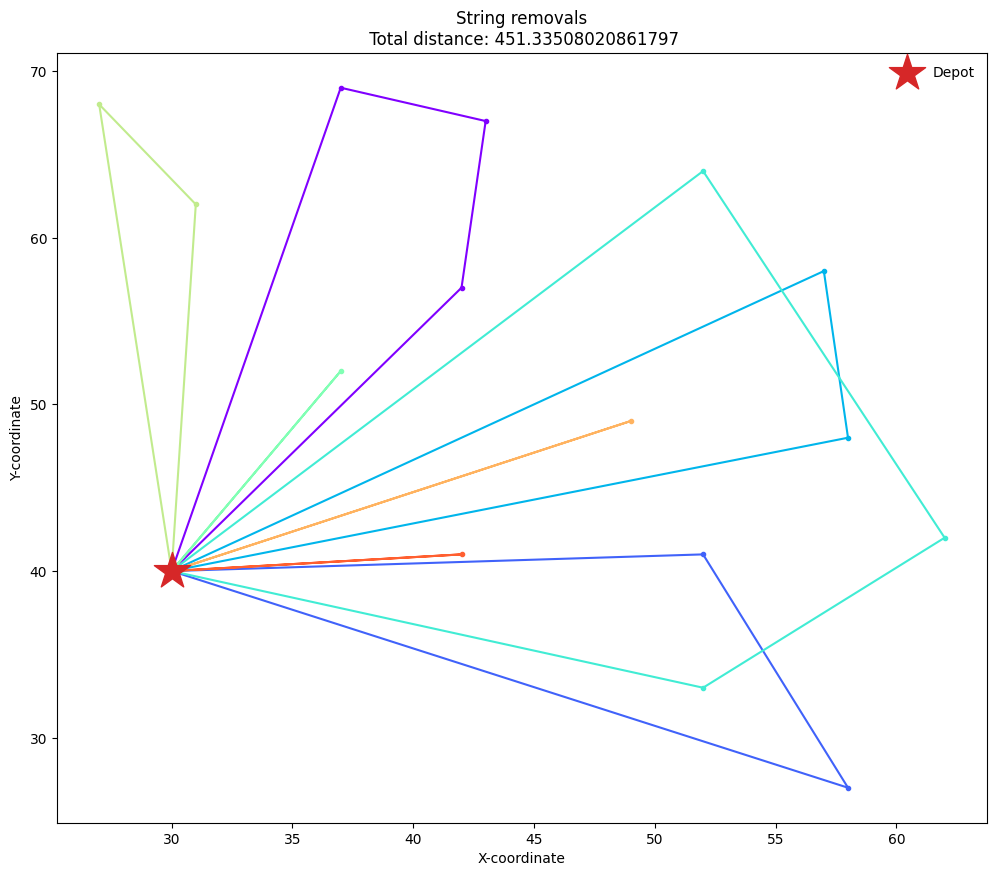

In [ ]:
import time
start_time = time.time()
alns = ALNS(rnd.default_rng(SEED))
#alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(string_removal)
alns.add_repair_operator(greedy_repair)
num_iterations = 30000
init = nearest_neighbor()
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = RecordToRecordTravel.autofit(init.objective(), 0.02, 0, num_iterations)
stop = MaxIterations(num_iterations)
result = alns.iterate(init, select, accept, stop)
solution = result.best_state
objective = solution.objective()
pct_diff = 100 * (objective - bks.cost) / bks.cost
print(f"Best heuristic objective is {objective}, iterations={num_iterations}.")
print(f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bks.cost}.")
plot_solution(solution, "String removals")
end_time = time.time()
elapsed = end_time - start_time
print(f"실행 시간: {elapsed:.6f} 초")

In [ ]:
print("Destroy operators:", alns.destroy_operators)

Destroy operators: [('random_removal', <function random_removal at 0x7dda719991c0>), ('string_removal', <function string_removal at 0x7dda7105ba60>)]


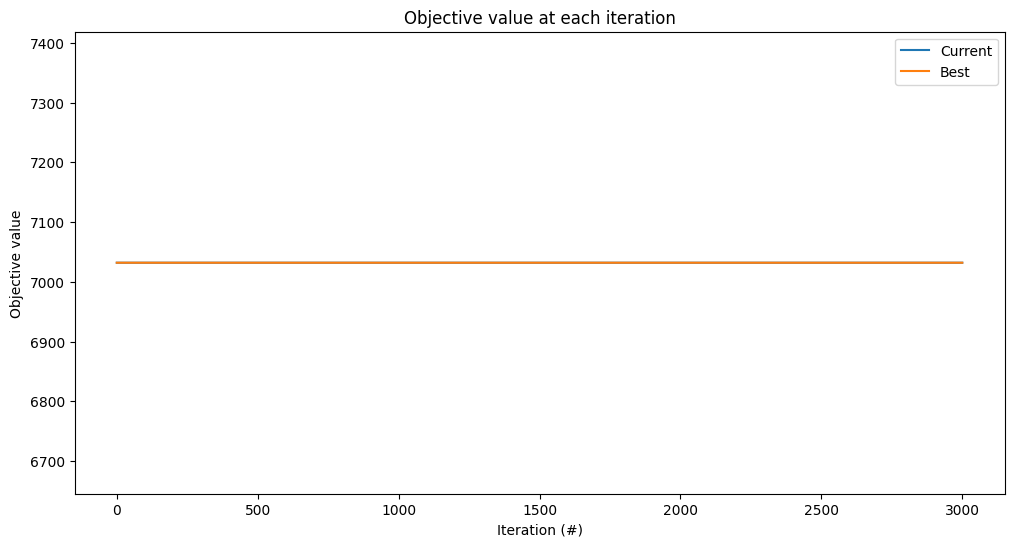

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

Best heuristic objective is 6208.0, iterations=3000.
This is 0.0% worse than the optimal solution, which is 6208.


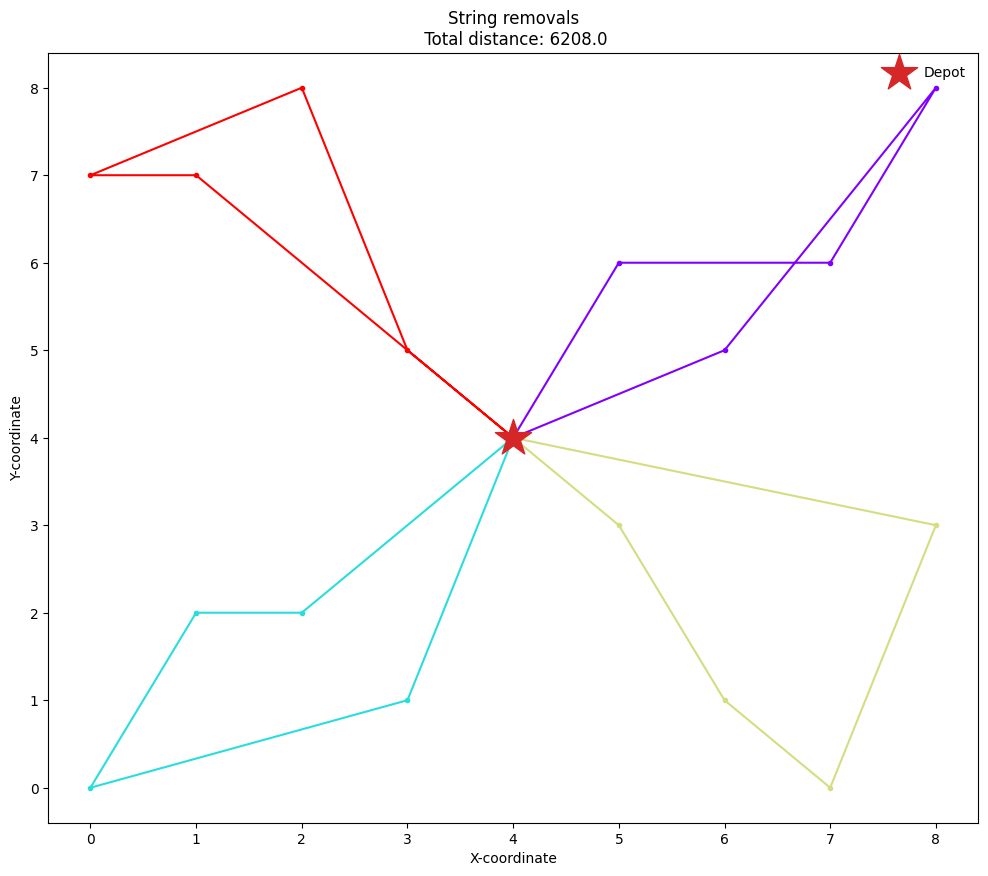

In [ ]:
solution = result.best_state
objective = solution.objective()
pct_diff = 100 * (objective - bks.cost) / bks.cost
print(f"Best heuristic objective is {objective}, iterations={num_iterations}.")
print(f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bks.cost}.")
plot_solution(solution, "String removals")

#Conclusion

**Conclusions**

In this notebook we implemented two heuristics for the CVRP, using the ALNS meta-heuristic framework.

The first heuristic used a random customer destroy operator and we obtained a solution which is 10% worse than the best known solution.

The second heuristic used a destroy operator which removes strings arround a randomly selected customer and we obtained a solution that is only 3% worse than the best known solution.

This example shows that by constructing problem-specific operators, one can create even more powerful ALNS heuristics.